# Credits to

[1] https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2 

[2] https://www.kaggle.com/ragnar123/very-fst-model

[3] https://www.kaggle.com/mayer79/m5-forecast-poisson-loss

# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import gc
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import time
import pickle
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_poisson_deviance

# Reduce Memory Usage 

Run this function on dataframes to reduce the memory usage.

In [2]:
'''
Got from: [1]
'''
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Create file to store encoders

In [3]:
encoder_file = open('encoders', 'wb')

# Prepare Dataframes

In [4]:
'''
Got from: [1]
'''
path = "../input/m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [5]:
'''
Got from: [1]
- The columns "Date" and "Weekday" are dropped as they contain redundant information.
- Normally, the column "d" is like "d_1,d_2,...". Make it "1,2,.." and the type integer
- If there is no event (I think), there is NA. We will replace them with "NoEvent" string. Originally, it was replaced with
  "missing", but I don't think it makes sense as I don't think there is missing information, I think they just left 
  the days without any event as NA.
- We enumerate most of the columns:
    - We do not enumerate "d" and "wm_yr_weak" because we will use these columns for joins.
    - Why do we enumerate month and day? I think it is because they start from 1, not 0.
    - Originally, the binary columns "snap_X" were also enumerated. I don't think it is necessary. The only neccessary step
      was to convert their type from int64 to int as it uses less space; but reduce_mem_usage will take care of that.
- I would suggest saving the OrdinalEncoder in case we need to reverse the transformations
'''
def prep_calendar(df,encoder_file):
    df = df.drop(["date", "weekday"], axis=1)  
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("NoEvent")
    cols = list(set(df.columns) - {"wm_yr_wk", "d","snap_CA","snap_TX","snap_WI"}) 
    oe = OrdinalEncoder(dtype="int")
    df[cols] = oe.fit_transform(df[cols])
    pickle.dump(oe,encoder_file)
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar,encoder_file)

Mem. usage decreased to  0.03 Mb (85.4% reduction)


In [6]:
'''
Got from: [1]
Originally, there were features added in this part. I excluded them until we decide whether to use those or not.
'''
def prep_selling_prices(df):
    df = reduce_mem_usage(df)
    return df

selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [7]:
'''
Got from: [1]
- We drop the first "drop_d" days. Originally, this is set to 1000. When it is set to this value,
  the shape we get 29,544,810 rows. When we don't set it, we get 60,034,810 rows. I think for now 
  we can keep this functionality, as it may be useful if we would like to discard some of the days.
- In some id's, we have "_validation". Those are deleted.
- reindex: Conform DataFrame to new index with optional filling logic (obtained from pandas doc). 
  We add days 1914+2*28 to prepare data from submission
- We have to melt the sales dataframe since days are contained as columns.
- assign: Returns a new object with all original columns in addition to new ones. Existing columns 
  that are re-assigned will be overwritten (obtained from pandas doc). Again, we make the values 
  "d_1, d-2,..." to "1,2,..."
'''
#We have to melt sales for sure because the days are columns, which is not desirable.
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

sales = reshape_sales(sales)

# Merge Dataframes

In [8]:
'''
Got from: [1]
- Merge all the dataframes and delete the unnecessary ones
- time.sleep() added to make sure garbage collector finishes its job before the next merge
'''
sales = sales.merge(calendar, how="left", on="d")
del calendar
gc.collect()
time.sleep(5)
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
del selling_prices
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
time.sleep(5)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN


# Encode some variables

In [9]:
'''
Got from: [1]
- We will also save the encoders in the pickle file.
- The loop is slightly changed
'''

cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]

# In loop to minimize memory use
for col in cat_id_cols:
    oe = OrdinalEncoder(dtype="int")
    sales[col] = oe.fit_transform(sales[[col]])
    pickle.dump(oe,encoder_file)    
sales = reduce_mem_usage(sales)
gc.collect()

Mem. usage decreased to 2175.64 Mb (51.3% reduction)


0

In [10]:
#for col in sales.columns:
#    if (col != 'd') and (col != 'id'):
#        sales[col] = sales[col] + 1

In [11]:
#sales.loc[sales.sell_price.isna()] = 0

In [12]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1,0.0,0,0,0,19,2,3,1,0,0,0,NaN


# Feature Engineering

When we do train,test, validation split; for some time we have to store all data twice to be able to divide the dataset. And every feature we add increases the size of the dataset drastically. Hence, if you have memory issues, I would suggest doing this part after splitting, even if it means we have to execute each line 3 times (for train,test,valid). And we have to be careful for the first few rows because these features sometimes depend on previous datapoints; which may be found in train set for first few rows of validation, for example.

KNN also may require some extra data storage. Moreover, in that case, this part can be even after KNN. This way, you can also use imputed selling prices to calculate your new features.

In [13]:
'''
Got from: [1]
- These features were originally added in prep_selling_prices function to the 
  selling_prices dataframe, which does not exist anymore. But we can use the same
  code to add these to sales dataframe as well as the columns are the same.
- New feature="sell_price_rel_diff"
  pct_change(): Computes the percentage change from the immediately previous row by default. (Obtained from pandas doc.)
  The two lines below adds the percentage of change of each item that is sold in the stores. Of course, for the
  first datapoint, there is no previous, so this code produces an NA. Since there are 3049x10=30490 different (item,store)
  pairs, this new column has 30490 NAs.
- New feature="sell_price_roll_sd7"
  Rolling standard deviation: Moving Standard Deviation is a statistical measurement of market volatility (Google). We check the
  past 7 days.
- New feature="sell_price_cumrel"
  I think this is cumulative related frequency. I am not sure and I did not understand it clearly. I think
  it is some kind of normalization, because we subtract the minimum and divide by max-min+1.
- It runs without problems, but the RAM gets almost filled up so it gives you a heart attack.
- No need to call reduce_mem_usage() after as I tried and it did not save any additional space.
'''

gr = sales.groupby(["store_id", "item_id"])["sell_price"]
sales["sell_price_rel_diff"] = gr.pct_change()
sales["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())

del gr
gc.collect()



0

In [14]:
'''
Got from: [1]
Appearantly, [1] derived the features from [2].

- The features include rolling means and standard deviations for different number of days.
  I think this is also a measure of market volatiliy.
- After this, original notebook deletes rows producing NAs. 'rolling_mean_t180' produces the most NAs as I
  believe the value of first 180 days will be NA because to compute this we need 180 days prior. I do not 
  know whether adding these features is so important to delete that much data. Hence, I will keep it for now.
  I think time ranges can also be changed.
'''

gr = sales.groupby(["id"])["demand"]
sales['lag_t28'] = gr.transform(lambda x: x.shift(28))
sales['rolling_mean_t7'] = gr.transform(lambda x: x.shift(28).rolling(7).mean())
sales['rolling_mean_t30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())
#sales['rolling_mean_t60'] = gr.transform(lambda x: x.shift(28).rolling(60).mean())
#sales['rolling_mean_t90'] = gr.transform(lambda x: x.shift(28).rolling(90).mean())
#sales['rolling_mean_t180'] = gr.transform(lambda x: x.shift(28).rolling(180).mean())
sales['rolling_std_t7'] = gr.transform(lambda x: x.shift(28).rolling(7).std())
sales['rolling_std_t30'] = gr.transform(lambda x: x.shift(28).rolling(30).std())

del gr
sales = reduce_mem_usage(sales)
gc.collect()


Mem. usage decreased to 2977.19 Mb (0.0% reduction)


0

# Train Test Split

Naming convention:
* test, train, valid -> Use these to create your X_{train,valid,test}  and y_{train,valid}.
* Training data: X_train, y_train
* Validation data: X_valid, y_valid
* Testing data (Kaggle has the labels): X_test

X_{train,valid,test} should be preprocessed according to your model.

Since we will use test dataframe for submission and the submission is obtained from another person, make sure the order of X_test and test is the same.

This process increases memory usage from 6GB to 7.5GB and reduce_mem_usage() does not improve the situation. One idea can be to keep the flags generated but produce end datasets at the end.

In [15]:
'''
Got from: [1]
'''
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
gc.collect()

# One month of validation data
flag_valid = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = sales[flag_valid]
flag_train = sales.d < 1914 - 28
train = sales[flag_train]


del sales, flag_valid,flag_train
gc.collect()
time.sleep(5)

test.reset_index(drop=True)
valid.reset_index(drop=True)
train.reset_index(drop=True)

gc.collect()

0

# Impute NAs

Documentation says: If (selling_price) not available, this means that the product was not sold during the examined week. 

When we are not using recurrent structures, I think it is the
best if we just remove those rows. However, for recurrent structures, such as LSTM and GRU, it would be better if
the sequence was not broken. For those models, we can impute the missing labels with KNN. So there will be two
alternatives. Set impute_labels=True to impute, False to drop depending on your application.

Note that we have to do the imputation after we split the data to prevent leaking information.

Don't use the demand column not to leak data from the label.

I could not use KNN, SVR etc due to memory limitations.



In [16]:
print("NAs:\n",train.isna().sum())
impute_labels = True

if not impute_labels:
    train.dropna(inplace=True)
    valid.dropna(inplace=True)
    gc.collect()
    time.sleep(2)
else:
    to_be_inputed = ['sell_price_rel_diff','rolling_std_t7','rolling_std_t30','lag_t28','rolling_mean_t7','rolling_mean_t30']
    for col in to_be_inputed:
        mean_train = train[col].dropna().astype(float).mean(skipna=True)
        print(mean_train)
        train[col] = train[col].fillna(mean_train)
        valid[col] = valid[col].fillna(mean_train)
        test[col] = test[col].fillna(mean_train)
gc.collect()


NAs:
 id                            0
item_id                       0
dept_id                       0
cat_id                        0
store_id                      0
state_id                      0
d                             0
demand                        0
wday                          0
month                         0
year                          0
event_name_1                  0
event_type_1                  0
event_name_2                  0
event_type_2                  0
snap_CA                       0
snap_TX                       0
snap_WI                       0
sell_price             12299413
sell_price_rel_diff    12329903
sell_price_cumrel      12299413
lag_t28                  853720
rolling_mean_t7         1036660
rolling_mean_t30        1737930
rolling_std_t7          1036660
rolling_std_t30         1737930
dtype: int64
0.00018367665712512742
0.8926077546302423
1.020621013980436
1.1186116973298978
1.1184267308957285
1.1182921112654365


0

# Normalization

We have to normalize data for the models that are not tree based. 

In [17]:
#from sklearn.preprocessing import StandardScaler
#to_be_normalized = ['sell_price','sell_price_rel_diff','rolling_std_t7','rolling_std_t30','lag_t28','rolling_mean_t7','rolling_mean_t30']
#for col in to_be_normalized:
#    scaler = StandardScaler()
#    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
#    valid[col] = scaler.transform(valid[col].values.reshape(-1, 1))
#    test[col] = scaler.transform(test[col].values.reshape(-1, 1))
#    pickle.dump(scaler,encoder_file)
#    gc.collect()
#    time.sleep(2)

In [18]:
x = list(set(train.columns) - {'id', 'd', 'demand', 'sell_price_cumrel'})
train_part = train[train['year'] > 2]
del train

# Close encoder file

In [19]:
encoder_file.close()

** Enter description of the model here **

** Name your model "model" **

In [20]:
train_set = lgb.Dataset(train_part.drop(['id', 'demand','sell_price_cumrel'], axis=1), label = train_part['demand'])
del train_part
valid_set = lgb.Dataset(valid.drop(['id', 'demand', 'sell_price_cumrel'],axis=1), label = valid['demand'])
del valid

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.2901
[200]	valid_0's rmse: 2.26417
[300]	valid_0's rmse: 2.25292
[400]	valid_0's rmse: 2.25292
[500]	valid_0's rmse: 2.26061
Early stopping, best iteration is:
[321]	valid_0's rmse: 2.24931


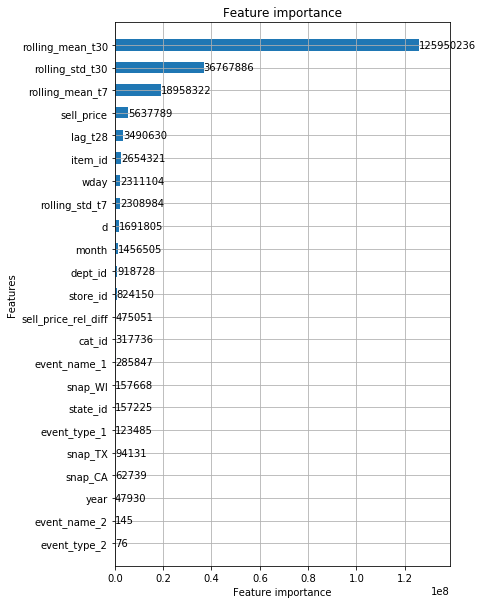

In [21]:
# taken from [3]
def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.1,
        'lambda': 0.1,
        'num_leaves': 63,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.77
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 2000, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

fit = fit_model(train_set, valid_set)

In [22]:
# taken from [3]
'''
def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True
pred_to_csv(fit, test, x)
'''

'\ndef pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):\n    """ Calculate predictions and append to submission csv """\n    \n    # Recursive prediction\n    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):\n        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])\n        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic\n    \n    # Prepare for reshaping\n    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),\n                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))\n    \n    # Reshape\n    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)\n    \n    # Export\n    submission.to_csv(file, index=False)\n    \n    return True\npred_to_csv(fit, test, x)\n'

# Model


## Libraries

In [23]:
'''
Got from: [1]
Prepare X_{train,valid,test} and y_{train,valid}
'''
'''
# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df,dense_cols):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

cat_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id","wday", "month", "event_name_1", 
            "event_type_1", "event_name_2", "event_type_2"]
dense_cols = ["lag_t28","rolling_mean_t7","rolling_mean_t30","rolling_std_t7","sell_price_rel_diff",
              "rolling_std_t30","snap_CA", "snap_TX", "snap_WI","year"]

X_test = make_X(test,dense_cols)
X_train = make_X(train,dense_cols)
y_train = train["demand"]
del train
gc.collect()
time.sleep(5)
X_valid = make_X(valid,dense_cols)
y_valid = valid["demand"]
del valid
gc.collect()
time.sleep(5)
'''

'\n# Input dict for training with a dense array and separate inputs for each embedding input\ndef make_X(df,dense_cols):\n    X = {"dense1": df[dense_cols].to_numpy()}\n    for i, v in enumerate(cat_cols):\n        X[v] = df[[v]].to_numpy()\n    return X\n\ncat_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id","wday", "month", "event_name_1", \n            "event_type_1", "event_name_2", "event_type_2"]\ndense_cols = ["lag_t28","rolling_mean_t7","rolling_mean_t30","rolling_std_t7","sell_price_rel_diff",\n              "rolling_std_t30","snap_CA", "snap_TX", "snap_WI","year"]\n\nX_test = make_X(test,dense_cols)\nX_train = make_X(train,dense_cols)\ny_train = train["demand"]\ndel train\ngc.collect()\ntime.sleep(5)\nX_valid = make_X(valid,dense_cols)\ny_valid = valid["demand"]\ndel valid\ngc.collect()\ntime.sleep(5)\n'

In [24]:
'''
Got from: [1]
- Added LSTM. Changed some hidden units, learning rate, batch size and number of epochs.
'''
'''
def create_model(lr=0.001):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(batch_shape=(30490, len(dense_cols)), name='dense1')

    # Embedding input
    wday_input = Input(batch_shape=(30490, 1), name='wday')
    month_input = Input(batch_shape=(30490, 1), name='month')
    #year_input = Input(batch_shape=(30490, 1),name='year')
    event_name_1_input = Input(batch_shape=(30490, 1), name='event_name_1')
    event_type_1_input = Input(batch_shape=(30490, 1), name='event_type_1')
    event_name_2_input = Input(batch_shape=(30490, 1), name='event_name_2')
    event_type_2_input = Input(batch_shape=(30490, 1), name='event_type_2')
    item_id_input = Input(batch_shape=(30490, 1), name='item_id')
    dept_id_input = Input(batch_shape=(30490, 1), name='dept_id')
    store_id_input = Input(batch_shape=(30490, 1), name='store_id')
    cat_id_input = Input(batch_shape=(30490, 1), name='cat_id')
    state_id_input = Input(batch_shape=(30490, 1), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
   #year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 10)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Reshape((30,1))(x)
    est = tf.estimator.BoostedTreesRegressor(30, n_batches_per_layer=1)
    est.train(x, max_steps=500)
    x = est.predict(x)
    #x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model
'''

'\ndef create_model(lr=0.001):\n    tf.random.set_seed(173)\n\n    tf.keras.backend.clear_session()\n    gc.collect()\n\n    # Dense input\n    dense_input = Input(batch_shape=(30490, len(dense_cols)), name=\'dense1\')\n\n    # Embedding input\n    wday_input = Input(batch_shape=(30490, 1), name=\'wday\')\n    month_input = Input(batch_shape=(30490, 1), name=\'month\')\n    #year_input = Input(batch_shape=(30490, 1),name=\'year\')\n    event_name_1_input = Input(batch_shape=(30490, 1), name=\'event_name_1\')\n    event_type_1_input = Input(batch_shape=(30490, 1), name=\'event_type_1\')\n    event_name_2_input = Input(batch_shape=(30490, 1), name=\'event_name_2\')\n    event_type_2_input = Input(batch_shape=(30490, 1), name=\'event_type_2\')\n    item_id_input = Input(batch_shape=(30490, 1), name=\'item_id\')\n    dept_id_input = Input(batch_shape=(30490, 1), name=\'dept_id\')\n    store_id_input = Input(batch_shape=(30490, 1), name=\'store_id\')\n    cat_id_input = Input(batch_shape=(3

In [25]:
'''
model = create_model(0.001)
history = model.fit(X_train, y_train,batch_size=30490,epochs=10,shuffle=False,
                    validation_data=[X_valid,y_valid])
                    '''

'\nmodel = create_model(0.001)\nhistory = model.fit(X_train, y_train,batch_size=30490,epochs=10,shuffle=False,\n                    validation_data=[X_valid,y_valid])\n                    '

In [26]:
'''
Got from: [1]
'''
'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
'''

"\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'valid'], loc='upper left')\nplt.show()\n"

In [27]:
#model.save("model.h5")

# Submission

In [28]:
'''
Got from: [1]
'''

pred = fit.predict(test.drop(['id','F', 'demand','sell_price_cumrel'],axis=1))
test["demand"] = pred.clip(0)
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.to_csv("submission.csv", index=False)
